## Reproduce In-situ Sequencing results with Starfish

This notebook walks through a work flow that reproduces an ISS result for one field of view using the starfish package.

## Load tiff stack and visualize one field of view

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from showit import image
import pprint

from starfish.experiment import Experiment
from starfish.constants import Indices, Features
from starfish.codebook import Codebook

In [2]:
experiment = Experiment()
experiment.read('https://dmf0bdeheu4zf.cloudfront.net/20180813/ISS/fov_001/experiment.json')
# s.image.squeeze() simply converts the 4D tensor H*C*X*Y into a list of len(H*C) image planes for rendering by 'tile'

## Show input file format that specifies how the tiff stack is organized

The stack contains multiple single plane images, one for each color channel, 'c', (columns in above image) and imaging round, 'r', (rows in above image). This protocol assumes that genes are encoded with a length 4 quatenary barcode that can be read out from the images. Each round encodes a position in the codeword. The maximum signal in each color channel (columns in the above image) corresponds to a letter in the codeword. The channels, in order, correspond to the letters: 'T', 'G', 'C', 'A'. The goal is now to process these image data into spatially organized barcodes, e.g., ACTG, which can then be mapped back to a codebook that specifies what gene this codeword corresponds to.

In [3]:
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(experiment.format_metadata)

{ 'auxiliary_images': {'dots': 'dots.json', 'nuclei': 'nuclei.json'},
  'codebook': 'codebook.json',
  'hybridization_images': 'hybridization.json',
  'version': '1.0.0'}


The flat TIFF files are loaded into a 4-d tensor with dimensions corresponding to imaging round, channel, x, and y. For other volumetric approaches that image the z-plane, this would be a 5-d tensor.

In [4]:
# round, channel, x, y, z
experiment.image.numpy_array.shape

(4, 4, 1, 1044, 1390)

## Show auxiliary images captured during the experiment

'dots' is a general stain for all possible transcripts. This image should correspond to the maximum projcection of all color channels within a single imaging round. This auxiliary image is useful for registering images from multiple imaging rounds to this reference image. We'll see an example of this further on in the notebook

<IPython.core.display.Javascript object>


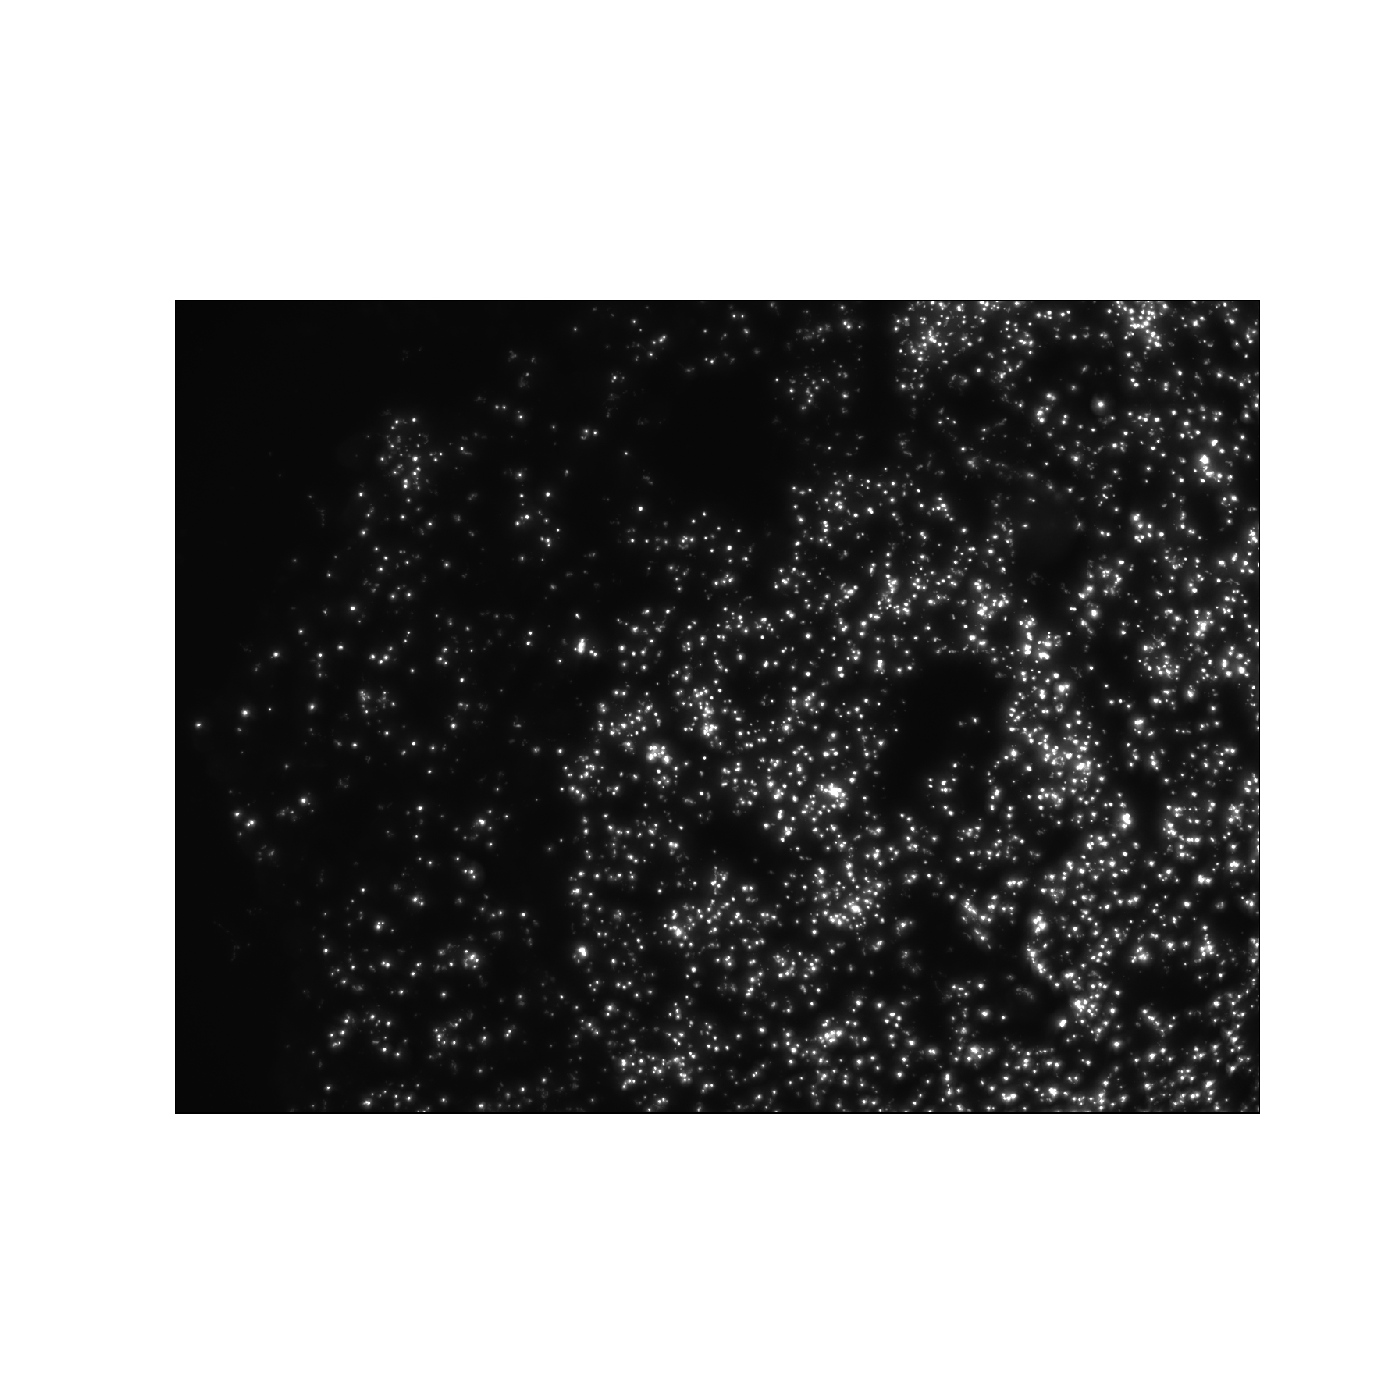

In [5]:
image(experiment.auxiliary_images['dots'].max_proj(Indices.ROUND, Indices.CH, Indices.Z))

Below is a DAPI auxiliary image, which specifically marks nuclei. This is useful cell segmentation later on in the processing.

<IPython.core.display.Javascript object>


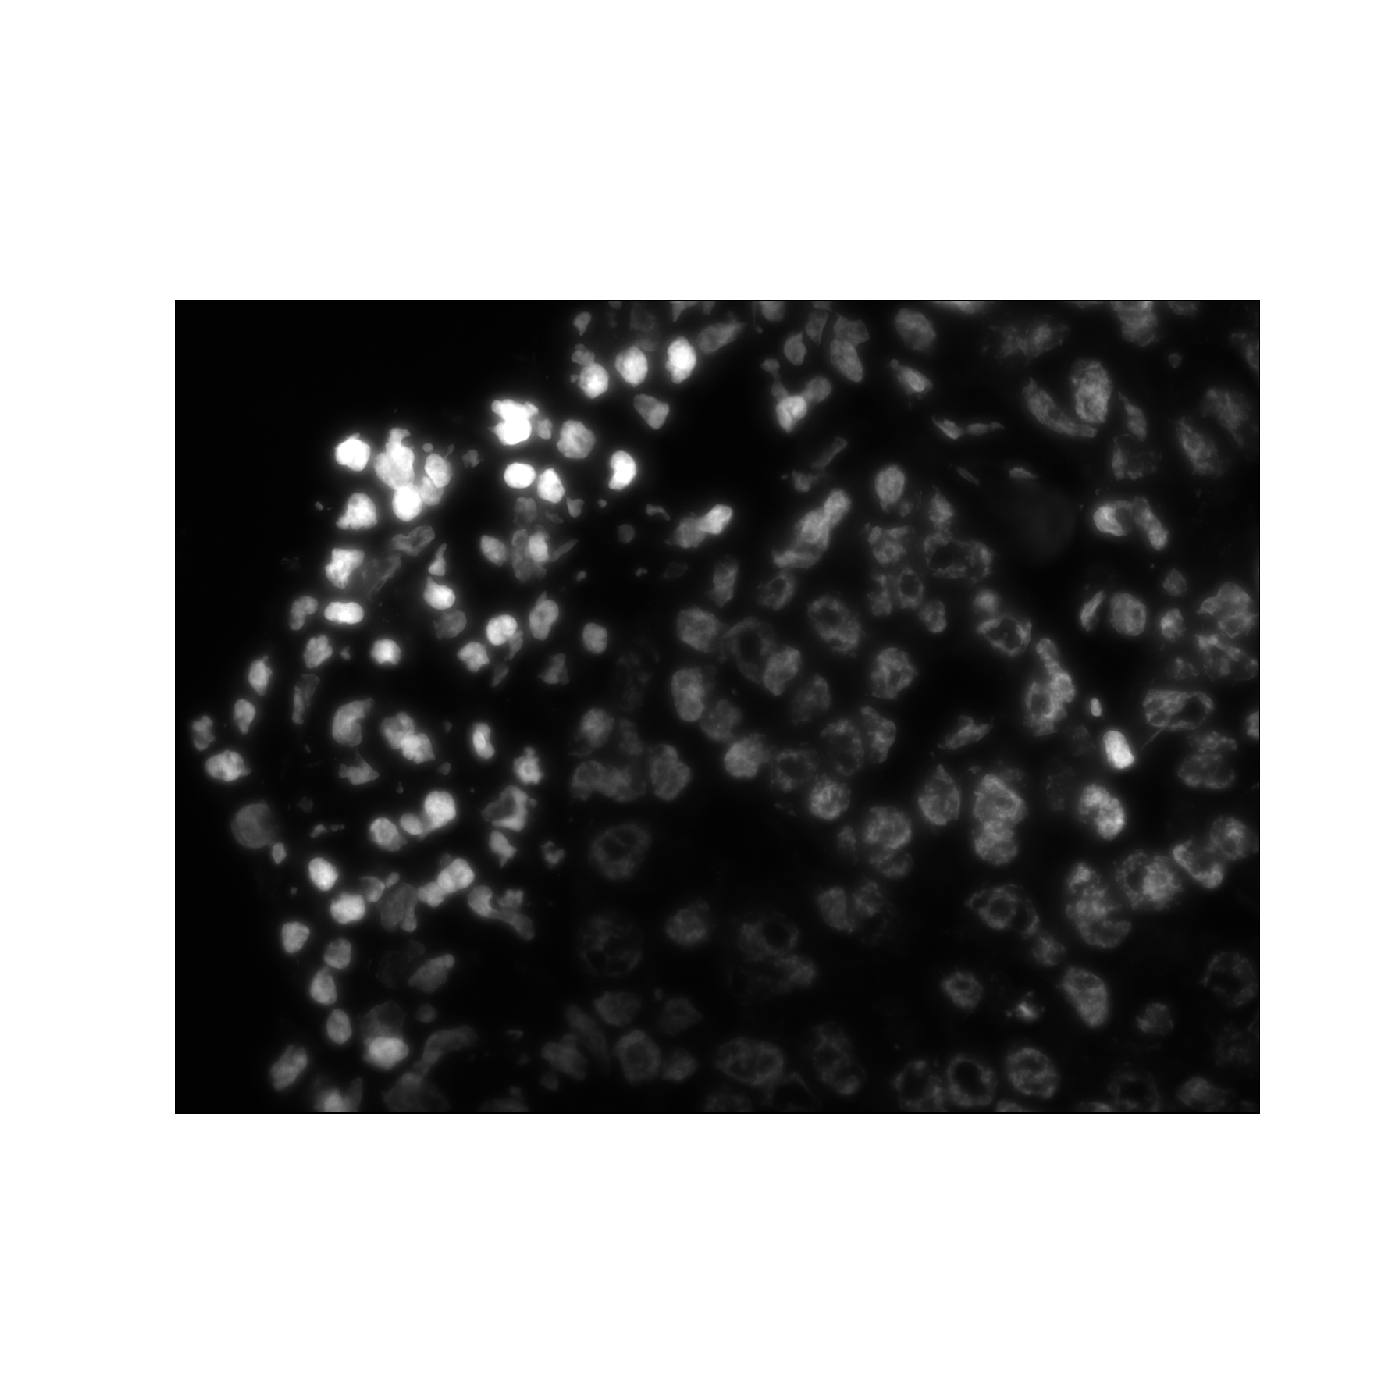

In [6]:
image(experiment.auxiliary_images['nuclei'].max_proj(Indices.ROUND, Indices.CH, Indices.Z))

## Examine the codebook

Each 4 letter quatenary code (as read out from the 4 imaging rounds and 4 color channels) represents a gene. This relationship is stored in a codebook

In [7]:
codebook = Codebook.from_json('https://dmf0bdeheu4zf.cloudfront.net/20180722/ISS/codebook.json')
codebook

<xarray.Codebook (target: 31, c: 4, r: 4)>
array([[[0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]],

       [[0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [1, 0, 0, 0]],

       ...,

       [[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]],

       [[0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]]], dtype=uint8)
Coordinates:
  * target   (target) object 'SCUBE2' 'MYBL2' 'ER' 'ST-3' 'BCL2' 'MET' ...
  * c        (c) int64 0 1 2 3
  * r        (r) int64 0 1 2 3

## Filter and scale raw data

Now apply the white top hat filter to both the spots image and the individual channels. White top had enhances white spots on a black background.

In [11]:
primary_image = experiment.image
dots = experiment.auxiliary_images['dots']
nuclei = experiment.auxiliary_images['nuclei']
images = [primary_image, nuclei, image]

In [12]:
from starfish.image import Filter

# filter raw data
masking_radius = 15
filt = Filter.WhiteTophat(masking_radius, is_volume=False)
for img in images:
    filt.run(img, verbose=True)

## Register data

For each imaging round, the max projection across color channels should look like the dots stain.
Below, this computes the max projection across the color channels of an imaging round and learns the linear transformation to maps the resulting image onto the dots image.

The Fourier shift registration approach can be thought of as maximizing the cross-correlation of two images.

In the below table, Error is the minimum mean-squared error, and shift reports changes in x and y dimension.

In [ ]:
from starfish.image._registration import Registration

registration = Registration.FourierShiftRegistration(
    upsampling=1000, 
    reference_stack=dots,
    verbose=True)
registration.run(primary_image, verbose=True)

## Use spot-detector to create 'encoder' table  for standardized input  to decoder

Each pipeline exposes an encoder that translates an image into spots with intensities.  This approach uses a Gaussian spot detector.

In [ ]:
from starfish.pipeline.spots.detector import SpotFinder
import warnings

# parameters to define the allowable gaussian sizes (parameter space)
min_sigma = 1
max_sigma = 10
num_sigma = 30
threshold = 0.01

p = SpotFinder.GaussianSpotDetector(
    min_sigma=min_sigma,
    max_sigma=max_sigma,
    num_sigma=num_sigma,
    threshold=threshold,
    measurement_type='mean',
)

# detect triggers some numpy warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # blobs = dots; define the spots in the dots image, but then find them again in the stack.
    blobs_image = experiment.auxiliary_images['dots'].max_proj(Indices.ROUND, Indices.Z)
    intensities = p.find(experiment.image, blobs_image=blobs_image)

In [ ]:
# Verify the spot count is reasonable.
spot_count = intensities.shape[0]
assert 1000 < spot_count < 5000
spot_count

This visualizes a single spot (#100) across all imaging rounds and channels. It contains the intensity and bit index, which allow it to be mapped onto the correct barcode.

In [ ]:
intensities[100]

The Encoder table is the hypothesized standardized file format for the output of a spot detector, and is the first output file format in the pipeline that is not an image or set of images

`attributes` is produced by the encoder and contains all the information necessary to map the encoded spots back to the original image

`x, y` describe the position, while `x_min` through `y_max` describe the bounding box for the spot, which is refined by a radius `r`. This table also stores the intensity and spot_id.

## Decode

Each assay type also exposes a decoder. A decoder translates each spot (spot_id) in the Encoder table into a gene (that matches a barcode) and associates this information with the stored position. The goal is to decode and output a quality score that describes the confidence in the decoding.

There are hard and soft decodings -- hard decoding is just looking for the max value in the code book. Soft decoding, by contrast, finds the closest code by distance (in intensity). Because different assays each have their own intensities and error modes, we leave decoders as user-defined functions.

In [ ]:
decoded = codebook.decode_per_round_max(intensities)

## Compare to results from paper

Besides house keeping genes, VIM and HER2 should be most highly expessed, which is consistent here.

In [ ]:
genes, counts = np.unique(decoded[Features.TARGET], return_counts=True)
table = pd.Series(counts, index=genes).sort_values(ascending=False)

In [ ]:
assert table.index.get_loc('HER2') < 10
assert table.index.get_loc('VIM') < 10
table.head()

### Segment

After calling spots and decoding their gene information, cells must be segmented to assign genes to cells. This paper used a seeded watershed approach.

In [ ]:
from starfish.constants import Indices
from starfish.image._segmentation import _WatershedSegmenter

dapi_thresh = .16  # binary mask for cell (nuclear) locations
stain_thresh = .22  # binary mask for overall cells // binarization of stain
size_lim = (10, 10000)
disk_size_markers = None
disk_size_mask = None
min_dist = 57

stain = np.mean(experiment.image.max_proj(Indices.CH, Indices.Z), axis=0)
stain = stain/stain.max()
nuclei = experiment.auxiliary_images['nuclei'].max_proj(Indices.ROUND, Indices.CH, Indices.Z)


seg = _WatershedSegmenter(nuclei, stain)  # uses skimage watershed.
cells_labels = seg.segment(dapi_thresh, stain_thresh, size_lim, disk_size_markers, disk_size_mask, min_dist)
seg.show()

### Visualize results

This FOV was selected to make sure that we can visualize the tumor/stroma boundary, below this is described by pseudo-coloring `HER2` (tumor) and vimentin (`VIM`, stroma)

In [ ]:
from skimage.color import rgb2gray

GENE1 = 'HER2'
GENE2 = 'VIM'

rgb = np.zeros(experiment.image.tile_shape + (3,))
rgb[:,:,0] = experiment.auxiliary_images['nuclei'].max_proj(Indices.ROUND, Indices.CH, Indices.Z)
rgb[:,:,1] = experiment.auxiliary_images['dots'].max_proj(Indices.ROUND, Indices.CH, Indices.Z)
do = rgb2gray(rgb)
do = do/(do.max())

image(do,size=10)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    is_gene1 = decoded.where(decoded[Features.AXIS][Features.TARGET] == GENE1, drop=True)
    is_gene2 = decoded.where(decoded[Features.AXIS][Features.TARGET] == GENE2, drop=True)

plt.plot(is_gene1.x, is_gene1.y, 'or')
plt.plot(is_gene2.x, is_gene2.y, 'ob')
plt.title(f'Red: {GENE1}, Blue: {GENE2}');